# Quadratic model

**Author:** Hannu Parviainen </br>
**Last updated:** 9 Feb 2023

The quadratic model, `pytransit.QuadraticModel`, implements a transit over a stellar disk with the stellar limb darkening described using the quadratic limb darkening model as described by Mandel & Agol (ApJ 580, 2002). The model is parallelised using numba, and the number of threads can be set using the `NUMBA_NUM_THREADS` environment variable. An OpenCL version for GPU computation is implemented by `pytransit.QuadraticModelCL`, and is discussed later in this notebook.

In [1]:
%pylab inline 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.append('..')

In [3]:
from pytransit import QuadraticModel

In [4]:
npv = 50
seed(0)

times_sc = linspace(0.85, 1.15, 1000)  # Short cadence time stamps
times_lc = linspace(0.85, 1.15,  100)  # Long cadence time stamps

k, t0, p, a, i, e, w  = 0.1, 1., 2.1, 3.2, 0.5*pi, 0.3, 0.4*pi
ldc = array([0.3, 0.1])

ks    = normal(k, 0.002, npv)
t0s   = normal(t0, 0.004, npv)
ps    = normal(p, 0.01, npv)
smas  = normal(a, 0.1, npv)
incs  = uniform(0.49*pi, 0.5*pi, npv)
es    = uniform(0, 0.25, npv)
ws    = uniform(0, 2*pi, npv)
ldc   = uniform(0.1, 0.5, size=(npv, 2))

## Model initialization

The quadratic model doesn't take any special initialization arguments, so the initialization is straightforward. 

In [5]:
tm = QuadraticModel()

## Data setup
### Homogeneous time series

The model needs to be set up by calling `set_data()` before it can be used. At its simplest, `set_data` takes the mid-exposure times of the time series to be modelled.

In [6]:
tm.set_data(times_sc)

## Model use

**Evaluation**
The transit model can be evaluated using either a set of parameters, a parameter vector (1D ndarray). The model flux is returned as a 1D ndarray in the first two cases, and a 2D ndarray in the last (one model per parameter vector).

  - `tm.evaluate(k, ldc, t0, p, a, i, e=0, w=0)` evaluates the model for a set of parameters, where `k` is the radius ratio, `ldc` is the limb darkening coefficient vector, `t0` the zero epoch, `p` the orbital period, `a` the semi-major axis divided by the stellar radius, `i` the inclination in radians, `e` the eccentricity, and `w` the argument of periastron. Eccentricity and argument of periastron are optional, and omitting them defaults to a circular orbit. 

**Limb darkening**
The quadratic limb darkening coefficients are given either as a 1D or 2D array, depending on whether the model is evaluated for a single set of parameters or an array of parameter vectors. In the first case, the coefficients can be given as `[u, v]`, and in the second, as `[[u1, v1], [u2, v2], ... [un, vn]]`. 

In the case of a heterogeneous time series with multiple passbands (more details below), the coefficients are given for a single parameter set as a 1D array with a length $2n_{pb}$ (`[u1, v1, u2, v2, ... un, vn]`, where the index now marks the passband), and for a parameter vector array as a 2D array with a shape `(npv, 2*npb)`, as

    [[u11, v11, u12, v12, ... u1n, v1n], 
     [u21, v21, u22, v22, ... u2n, v2n], 
     ...
     [un1, vn1, un2, vn2, ... unn, vnn]]
     

In [7]:
def plot_transits(tm, ldc, fmt='k'):
    fig, axs = subplots(1, 2, figsize = (13,3), constrained_layout=True, sharey=True)

    # Evaluate for scalar parameters
    flux = tm.evaluate(k, ldc[0], t0, p, a, i, e, w)
    axs[0].plot(tm.time, flux, fmt)
    axs[0].set_title('Scalar parameters')

    # Evaluate for npv parameters in parallel
    flux = tm.evaluate(ks, ldc, t0s, ps, smas, incs, es, ws)
    axs[1].plot(tm.time, flux.T, 'k', alpha=0.2)
    axs[1].set_title('Parameter vector')

    setp(axs[0], ylabel='Normalised flux')
    setp(axs, xlabel='Time [days]', xlim=tm.time[[0,-1]])

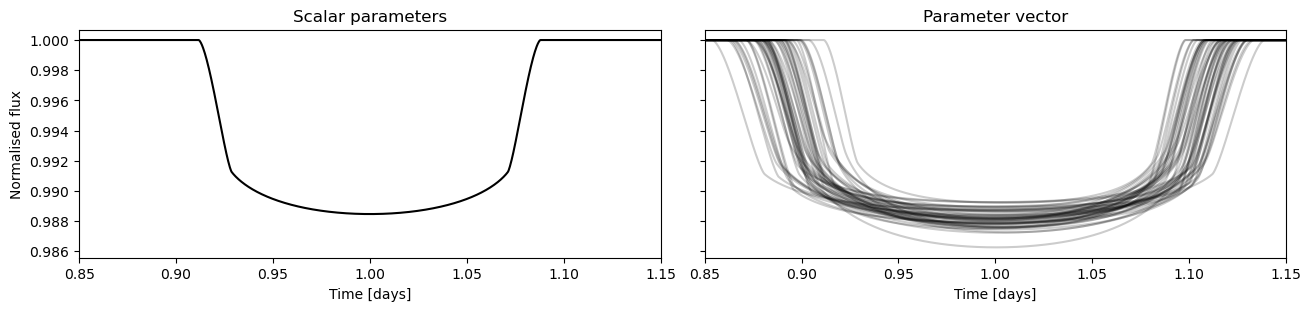

In [8]:
tm.set_data(times_sc)
plot_transits(tm, ldc)

## Supersampling

The transit model can be supersampled by setting the `nsamples` and `exptimes` arguments in `set_data`.

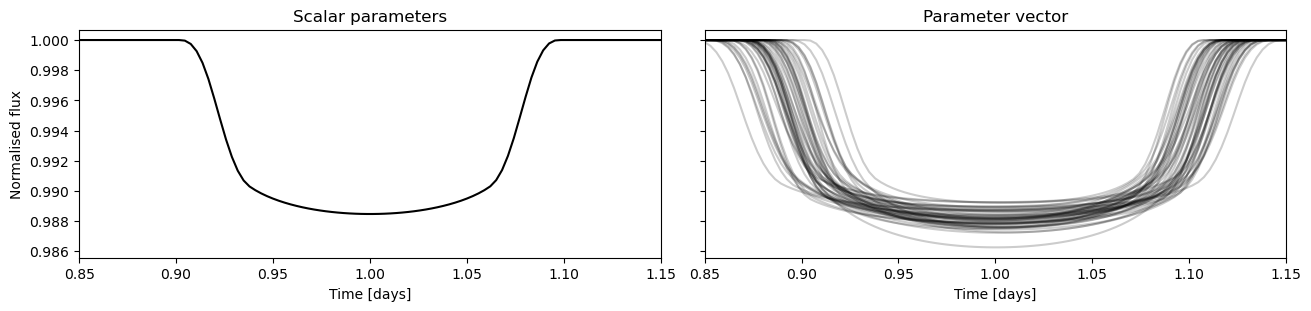

In [9]:
tm.set_data(times_lc, nsamples=10, exptimes=0.02)
plot_transits(tm, ldc)

## Heterogeneous time series

PyTransit allows for heterogeneous time series, that is, a single time series can contain several individual light curves (with, e.g., different time cadences and required supersampling rates) observed (possibly) in different passbands.

If a time series contains several light curves, it also needs the light curve indices for each exposure. These are given through `lcids` argument, which should be an array of integers. If the time series contains light curves observed in different passbands, the passband indices need to be given through `pbids` argument as an integer array, one per light curve. Supersampling can also be defined on per-light curve basis by giving the `nsamples`and `exptimes` as arrays with one value per light curve. 

For example, a set of three light curves, two observed in one passband and the third in another passband

    times_1 (lc = 0, pb = 0, sc) = [1, 2, 3, 4]
    times_2 (lc = 1, pb = 0, lc) = [3, 4]
    times_3 (lc = 2, pb = 1, sc) = [1, 5, 6]
    
Would be set up as

    tm.set_data(time  = [1, 2, 3, 4, 3, 4, 1, 5, 6], 
                lcids = [0, 0, 0, 0, 1, 1, 2, 2, 2], 
                pbids = [0, 0, 1],
                nsamples = [  1,  10,   1],
                exptimes = [0.1, 1.0, 0.1])
                
Further, each passband requires two limb darkening coefficients, so the limb darkening coefficient array for a single parameter set should now be

    ldc = [u1, v1, u2, v2]

where u and v are the passband-specific quadratic limb darkening model coefficients.

### Example: two light curves with different cadences and passbands

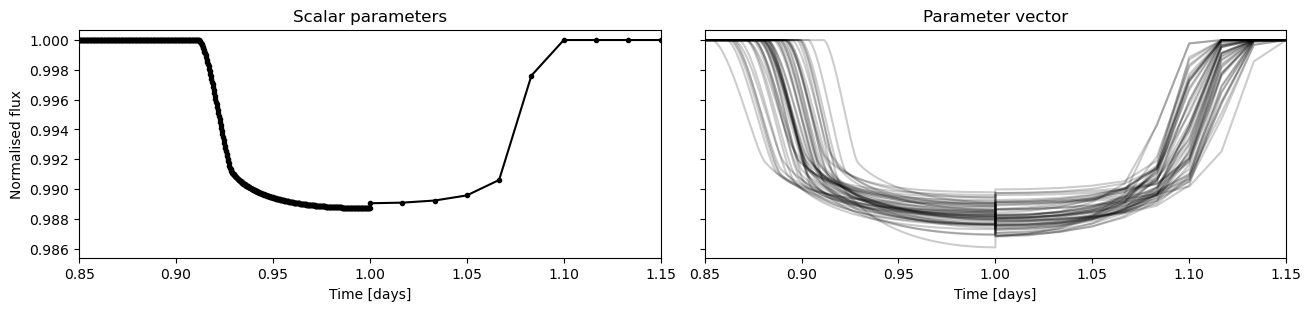

In [10]:
times_1 = linspace(0.85, 1.0, 500)
times_2 = linspace(1.0, 1.15,  10)
times = concatenate([times_1, times_2])
lcids = concatenate([full(times_1.size, 0, 'int'), full(times_2.size, 1, 'int')])
pbids = [0, 1]
nsamples = [1, 10]
exptimes = [0, 0.0167]
ldc2 = uniform(0.1, 0.5, (npv, 2, 2))

tm.set_data(times, lcids, pbids, nsamples=nsamples, exptimes=exptimes)
plot_transits(tm, ldc2, 'k.-')

## OpenCL
### Usage

The OpenCL version of the quadratic model, `pytransit.QuadraticModelCL` works identically to the Python version, except that the OpenCL context and queue can be given as arguments in the initialiser, and the model evaluation method can be told to not to copy the model from the GPU memory. If the context and queue are not given, the model creates a default context using `cl.create_some_context()`.

In [11]:
import pyopencl as cl
from pytransit import QuadraticModelCL

devices = cl.get_platforms()[0].get_devices()
ctx = cl.Context(devices)
queue = cl.CommandQueue(ctx)

tm_cl = QuadraticModelCL(cl_ctx=ctx, cl_queue=queue)

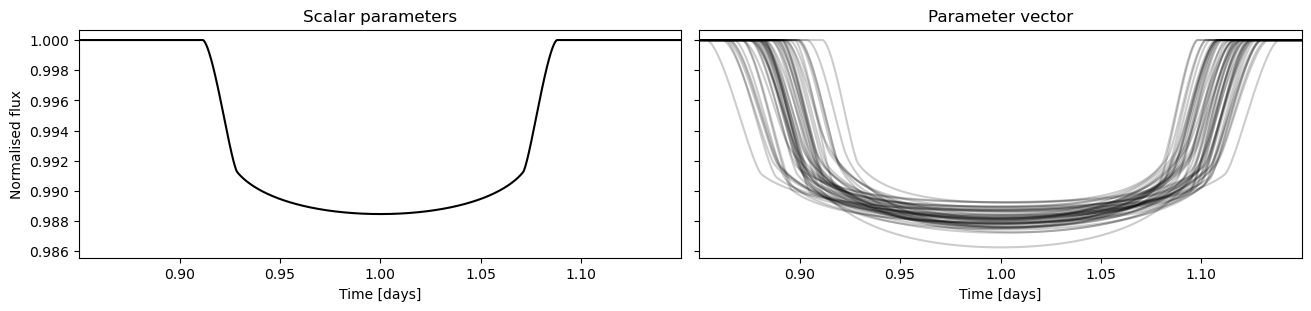

In [15]:
tm_cl.set_data(times_sc)
plot_transits(tm_cl, ldc)

### GPU vs. CPU Performance

The performance difference between the OpenCL and Python versions depends on the CPU, GPU, number of simultaneously evaluated models, amount of supersampling, and whether the model data is copied from the GPU memory. The performance difference grows in the favour of OpenCL model with the number of simultaneous models and amount of supersampling, but copying the data slows the OpenCL implementation down. For best performance, also the log likelihood computations should be done in the GPU.

In [16]:
times_sc2 = tile(times_sc, 20)  # 20000 short cadence datapoints
times_lc2 = tile(times_lc, 50)  #  5000 long cadence datapoints

In [17]:
tm_py = QuadraticModel()
tm_cl = QuadraticModelCL(cl_ctx=ctx, cl_queue=queue)

#### Short cadence data without heavy supersampling

In [18]:
tm_py.set_data(times_sc2)
tm_cl.set_data(times_sc2)

In [20]:
%%timeit
tm_py.evaluate(ks, ldc, t0s, ps, smas, incs, es, ws)

8.18 ms ± 71.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%%timeit
tm_cl.evaluate(ks, ldc, t0s, ps, smas, incs, es, ws, copy=True)

852 µs ± 5.51 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### Long cadence data with supersampling

In [22]:
tm_py.set_data(times_lc2, nsamples=10, exptimes=0.01)
tm_cl.set_data(times_lc2, nsamples=10, exptimes=0.01)

In [23]:
%%timeit
tm_py.evaluate(ks, ldc, t0s, ps, smas, incs, es, ws)

16 ms ± 80.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%%timeit
tm_cl.evaluate(ks, ldc, t0s, ps, smas, incs, es, ws, copy=True)

839 µs ± 4.75 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


---
<center>&copy; Hannu Parviainen 2010-2022</center>